In [101]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [103]:
list(enumerate(train.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'dropoff_datetime'),
 (4, 'passenger_count'),
 (5, 'pickup_longitude'),
 (6, 'pickup_latitude'),
 (7, 'dropoff_longitude'),
 (8, 'dropoff_latitude'),
 (9, 'store_and_fwd_flag'),
 (10, 'trip_duration')]

In [104]:
list(enumerate(test.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'passenger_count'),
 (4, 'pickup_longitude'),
 (5, 'pickup_latitude'),
 (6, 'dropoff_longitude'),
 (7, 'dropoff_latitude'),
 (8, 'store_and_fwd_flag')]

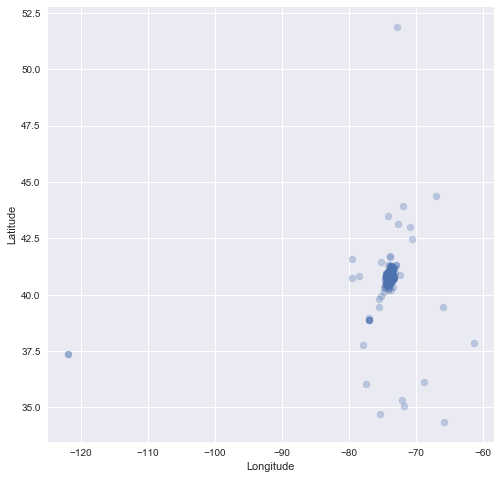

In [105]:
fig1 = plt.figure(figsize=(8, 8))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(x=train.pickup_longitude.values, y=train.pickup_latitude.values, alpha=.3)

In [106]:
fig1.savefig('./img/pickups_all.png')

In [107]:
type(train.pickup_latitude[0])

numpy.float64

(-74.099999999999994,
 -73.700000000000003,
 40.600000000000001,
 40.899999999999999)

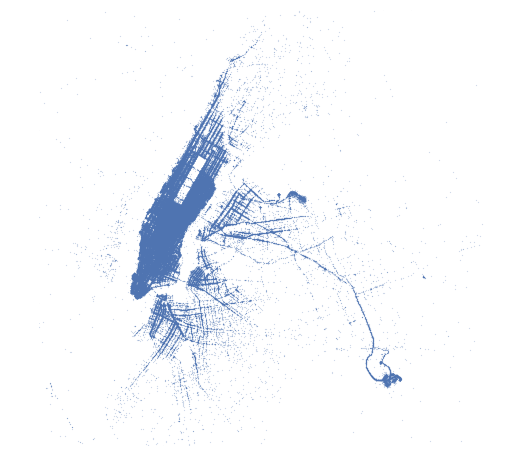

In [108]:
fig2 = plt.figure(figsize=(8, 8))
plt.scatter(x=train.pickup_longitude.values, y=train.pickup_latitude.values, s=1, alpha=.2)
plt.xlim([-74.1,-73.7])
plt.ylim([40.6, 40.9])
plt.axis('off')

In [109]:
fig2.savefig('./img/pickups_nyarea.png')

In [110]:
# Compute the correlation matrix
corr = train.corr()
print corr[~(corr == 1)].max(), corr.min()

vendor_id            0.287415
passenger_count      0.287415
pickup_longitude     0.783582
pickup_latitude      0.494038
dropoff_longitude    0.783582
dropoff_latitude     0.494038
trip_duration        0.026542
dtype: float64 vendor_id            0.001528
passenger_count     -0.005125
pickup_longitude     0.002169
pickup_latitude     -0.029204
dropoff_longitude   -0.000343
dropoff_latitude    -0.020677
trip_duration       -0.029204
dtype: float64


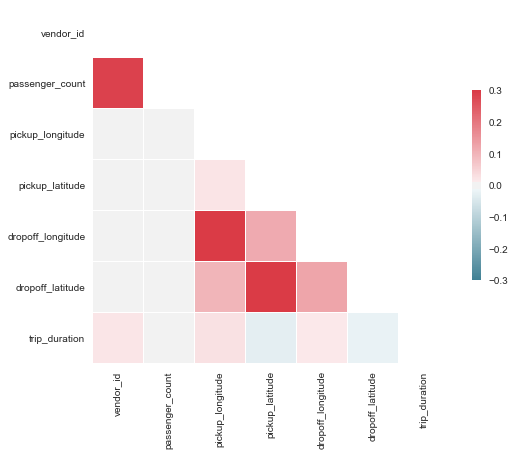

In [111]:
sns.set_style("whitegrid")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Label pickup points by Traffic Analysis Zone

In [112]:
# Load shapefile of NY state TAZ
taz_state = gpd.read_file('./data/tl_2011_36_taz10/tl_2011_36_taz10.shp')

In [113]:
taz_state.crs

{'init': u'epsg:4269'}

In [114]:
list(enumerate(taz_state.columns))

[(0, u'ALAND10'),
 (1, u'AWATER10'),
 (2, u'COUNTYFP10'),
 (3, u'FUNCSTAT10'),
 (4, u'GEOID10'),
 (5, u'INTPTLAT10'),
 (6, u'INTPTLON10'),
 (7, u'MPOCE10'),
 (8, u'MTFCC10'),
 (9, u'STATEFP10'),
 (10, u'TADCE10'),
 (11, u'TAZCE10'),
 (12, 'geometry')]

In [115]:
type(taz_state.COUNTYFP10[0])

unicode

In [116]:
nyc_county_codes = ['005','047','061','081','085']
taz_nyc = taz_state[taz_state.COUNTYFP10.isin(nyc_county_codes)]

In [117]:
len(taz_nyc)

2243

In [118]:
taz_nyc.TADCE10.head(10)

1139    00005008
1140    00005009
1141    00005014
1142    00005009
1143    00005009
1144    00005017
1145    00005017
1146    00005017
1147    00005016
1148    00005016
Name: TADCE10, dtype: object

In [119]:
# number of Traffic Analysis Districts
len(taz_nyc.TADCE10.unique())

179

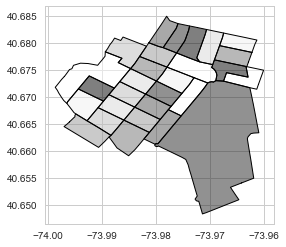

In [120]:
test_tad = taz_nyc[taz_nyc.TADCE10 == '00002014']
test_tad.plot()

In [121]:
len(test_tad)

28

In [122]:
# create identifier for county-tad pairs
# taz_nyc.groupby(['COUNTYFP10','TADCE10']).count()

#### Convert training set to a geodataframe

In [123]:
from shapely.geometry import Point

In [124]:
geometry = [Point(xy) for xy in zip(train.pickup_longitude, train.pickup_latitude)]
train_temp = train.drop(['pickup_longitude', 'pickup_latitude'], axis=1)
crs = {'init': 'epsg:4269'}
train_gdf = gpd.GeoDataFrame(train_temp, crs=crs, geometry=geometry)
train_gdf.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,geometry
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.964630,40.765602,N,455,POINT (-73.98215484619139 40.76793670654297)
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.999481,40.731152,N,663,POINT (-73.98041534423827 40.73856353759766)
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-74.005333,40.710087,N,2124,POINT (-73.97902679443358 40.76393890380859)
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.012268,40.706718,N,429,POINT (-74.01004028320312 40.719970703125)
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.972923,40.782520,N,435,POINT (-73.97305297851562 40.79320907592773)


In [ ]:
train_gdf.plot()

In [126]:
train_with_tad = gpd.sjoin(train_gdf, taz_nyc, how="inner", op='within')

In [ ]:
train_with_tad.to_file('data/train_with_tad.shp')

In [ ]:
# train_with_tad.columns

In [128]:
len(train_with_tad.TADCE10.unique())

0

#### Start here for training data already joined with TADs

In [4]:
train_with_tad = gpd.read_file('data/train_with_tad.shp')

In [5]:
# add lat/lon columns back in for faster plotting
train_with_tad['latitude'] = train_with_tad.geometry.apply(lambda x: x.coords[0][1])
train_with_tad['longitude'] = train_with_tad.geometry.apply(lambda x: x.coords[0][0])
train_with_tad.head()

,ALAND10,AWATER10,COUNTYFP10,FUNCSTAT10,GEOID10,INTPTLAT10,INTPTLON10,MPOCE10,MTFCC10,STATEFP10,...,geometry,id,index_righ,passenger_,pickup_dat,store_and_,trip_durat,vendor_id,latitude,longitude
0,178307,0,061,S,3606100014500,+40.7698085,-073.9842549,36198201,G6320,36,...,POINT (-73.98215484619139 40.76793670654297),id2875421,2424,1,2016-03-14 17:24:55,N,455,2,40.767937,-73.982155
1,178307,0,061,S,3606100014500,+40.7698085,-073.9842549,36198201,G6320,36,...,POINT (-73.98511505126955 40.76872634887695),id1886740,2424,1,2016-05-29 00:15:12,N,566,1,40.768726,-73.985115
2,178307,0,061,S,3606100014500,+40.7698085,-073.9842549,36198201,G6320,36,...,POINT (-73.98181915283203 40.76896286010742),id3487442,2424,1,2016-02-29 18:39:12,N,227,2,40.768963,-73.981819
3,178307,0,061,S,3606100014500,+40.7698085,-073.9842549,36198201,G6320,36,...,POINT (-73.984375 40.76968765258789),id3355874,2424,1,2016-02-04 11:24:26,N,1105,1,40.769688,-73.984375
4,178307,0,061,S,3606100014500,+40.7698085,-073.9842549,36198201,G6320,36,...,POINT (-73.98438262939453 40.77012634277344),id1459852,2424,1,2016-05-18 08:22:01,N,996,2,40.770126,-73.984383


In [ ]:
# type(train_with_tad.TADCE10[0])
# type(train_with_tad.latitude[0])

In [83]:
len(taz_nyc.TADCE10.unique())

179

In [97]:
# create a set of 179 colors (1 for each TAD)
cmap = plt.get_cmap('Set1')
colors = cmap(np.linspace(0, 1, len(taz_nyc.TADCE10.unique())))

# randomly shuffle the array so neighboring polygons are colored differently
np.random.shuffle(colors)
colors[:10]

array([[ 0.89411765,  0.10196078,  0.10980392,  1.        ],
       [ 0.59607843,  0.30588235,  0.63921569,  1.        ],
       [ 0.6       ,  0.6       ,  0.6       ,  1.        ],
       [ 0.89411765,  0.10196078,  0.10980392,  1.        ],
       [ 0.30196078,  0.68627451,  0.29019608,  1.        ],
       [ 0.59607843,  0.30588235,  0.63921569,  1.        ],
       [ 1.        ,  1.        ,  0.2       ,  1.        ],
       [ 1.        ,  0.49803922,  0.        ,  1.        ],
       [ 0.89411765,  0.10196078,  0.10980392,  1.        ],
       [ 0.21568627,  0.49411765,  0.72156863,  1.        ]])

In [98]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(colors)

########## 
# potentially try to use Seaborn color palette here
########## 

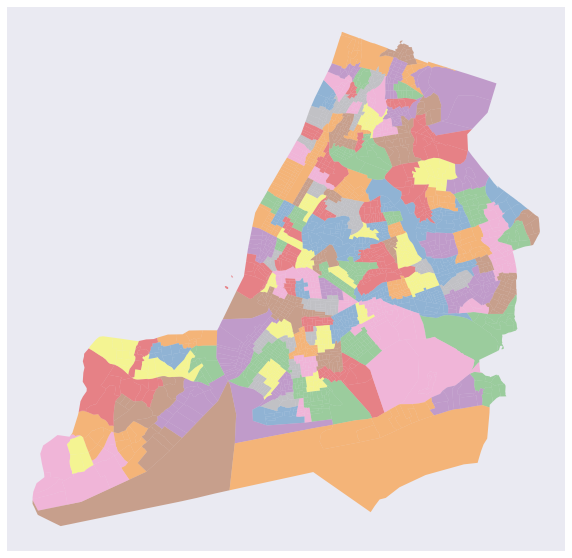

In [99]:
# plot the TADs
fig3, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
taz_nyc.plot(column='TADCE10', ax=ax, linewidth=0, colormap=cmap)
# plt.title("TITLE")

In [94]:
# dict matching TAD key with colors
color_dict = dict(zip(train_with_tad.TADCE10.unique(), colors))

In [ ]:
# test_tad = ['00001001', '00002014']
# test_df = train_with_tad[train_with_tad['TADCE10'].isin(test_tad)]
# fig3 = plt.figure(figsize=(12, 12))
# plt.scatter(x=test_df.longitude.values, y=test_df.latitude.values, s=1, alpha=1, \
#             c=test_df['TADCE10'].map(color_dict))
# plt.xlim([-74.1,-73.7])
# plt.ylim([40.6, 40.9])
# plt.axis('off')

(-74.099999999999994,
 -73.700000000000003,
 40.600000000000001,
 40.899999999999999)

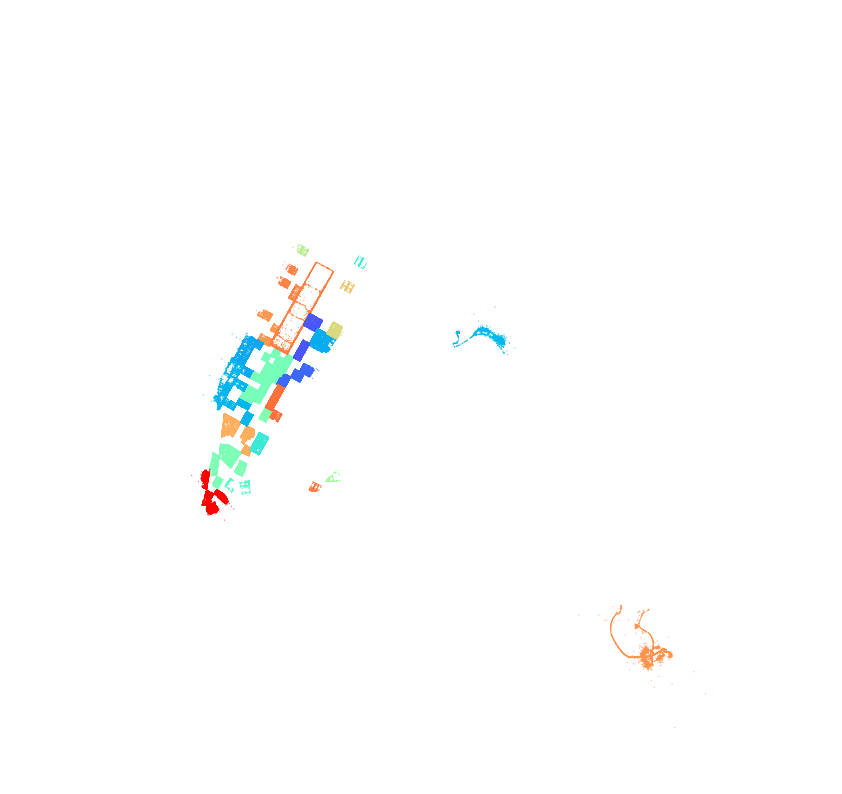

In [95]:
# plot pickup points colored by TAD, just to make sure the spatial join worked properly
fig4 = plt.figure(figsize=(14, 14))
plt.scatter(x=train_with_tad.longitude.values, y=train_with_tad.latitude.values, s=1, alpha=1, \
            lw=0, c=train_with_tad['TADCE10'].map(color_dict))
plt.xlim([-74.1,-73.7])
plt.ylim([40.6, 40.9])
plt.axis('off')

#### Street network data

In [6]:
import osmnx as ox
ox.config(log_file=True, log_console=True, use_cache=True)

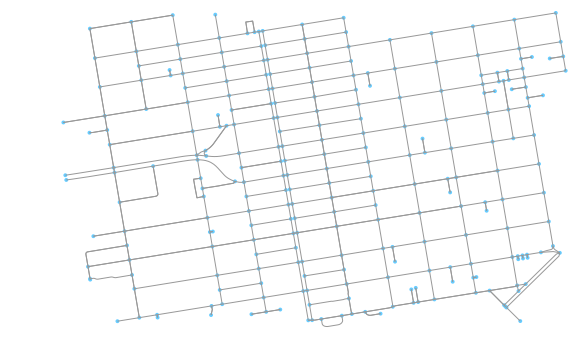

In [7]:
# example
# ----------------
# define a bounding box in San Francisco
north, south, east, west = 37.79, 37.78, -122.41, -122.43

# create network from that bounding box
G1 = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')
G1 = ox.project_graph(G1)
fig, ax = ox.plot_graph(G1)

(40.76793670654297, -73.98215484619139)


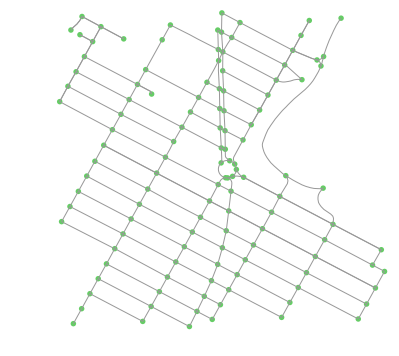

In [44]:
# get first point from training set
pickup_point = (train_gdf.geometry[0].y, train_gdf.geometry[0].x)
print pickup_point

# create network from point, inside bounding box of N, S, E, W each 750m from point
local_graph = ox.graph_from_point(pickup_point, distance=750, distance_type='bbox', network_type='drive')
local_graph = ox.project_graph(local_graph)
fig, ax = ox.plot_graph(local_graph, node_size=30, node_color='#66cc66')

In [45]:
stats = ox.basic_stats(local_graph)
stats

{'circuity_avg': 1.5386062670647417e-05,
 'count_intersections': 120,
 'edge_density_km': None,
 'edge_length_avg': 131.04356846587473,
 'edge_length_total': 29484.802904821816,
 'intersection_density_km': None,
 'k_avg': 3.658536585365854,
 'm': 225,
 'n': 123,
 'node_density_km': None,
 'self_loop_proportion': 0.0,
 'street_density_km': None,
 'street_length_avg': 130.5310980798852,
 'street_length_total': 25845.157419817268,
 'street_segments_count': 198,
 'streets_per_node_avg': 3.6747967479674797,
 'streets_per_node_counts': {0: 0, 1: 3, 2: 1, 3: 31, 4: 87, 5: 0, 6: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.024390243902439025,
  2: 0.008130081300813009,
  3: 0.25203252032520324,
  4: 0.7073170731707317,
  5: 0.0,
  6: 0.008130081300813009}}

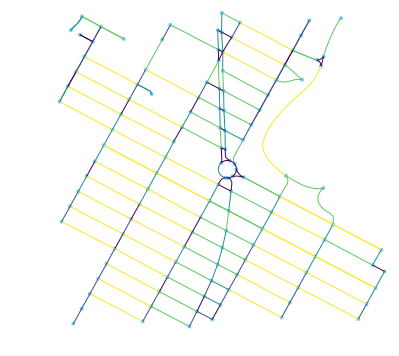

(<matplotlib.figure.Figure at 0x23e1dea90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23df76a50>)

In [46]:
# color edges by length; this type of color coding only seems to work for continuous attributes from osm
ec = ox.get_edge_colors_by_attr(local_graph, attr='length')
ox.plot_graph(local_graph, edge_color=ec)

In [47]:
# show osm data/attributes for the geometry obtained
local_graph.edges(keys=True, data=True)[:5]

[(42450434,
  42445033,
  0,
  {'geometry': <shapely.geometry.linestring.LineString at 0x23e013b10>,
   'highway': u'secondary',
   'lanes': u'4',
   'length': 273.06840633727234,
   'name': u'West 54th Street',
   'oneway': True,
   'osmid': 195743211}),
 (42450434,
  42440966,
  0,
  {'geometry': <shapely.geometry.linestring.LineString at 0x23e013ad0>,
   'highway': u'primary',
   'length': 81.349064499405472,
   'name': u'10th Avenue',
   'oneway': True,
   'osmid': 195743301}),
 (42430981,
  42454120,
  0,
  {'highway': u'residential',
   'length': 66.390486481107658,
   'name': u'West 62nd Street',
   'oneway': False,
   'osmid': 5672398}),
 (42430981,
  42421985,
  0,
  {'geometry': <shapely.geometry.linestring.LineString at 0x23e013fd0>,
   'highway': u'secondary',
   'length': 79.676958407430504,
   'name': u'West End Avenue',
   'oneway': False,
   'osmid': [420894368, 420894369, 420894363]}),
 (42430981,
  42430983,
  0,
  {'geometry': <shapely.geometry.linestring.LineString 

In [48]:
# create a gdf from the osm attributes and get the columns to show what the attributes are
edge_attributes = ox.graph_to_gdfs(local_graph, nodes=False).columns
print(edge_attributes)

Index([u'access', u'bridge', u'geometry', u'highway', u'key', u'lanes',
       u'length', u'maxspeed', u'name', u'oneway', u'osmid', u'tunnel', u'u',
       u'v', u'width'],
      dtype='object')


In [49]:
# simply create the gdf
edge_attr_data = ox.graph_to_gdfs(local_graph, nodes=False)
edge_attr_data.head()

,access,bridge,geometry,highway,key,lanes,length,maxspeed,name,oneway,osmid,tunnel,u,v,width
0,NaN,NaN,LINESTRING (585244.5675561909 4513403.32720782...,secondary,0,4,273.068406,NaN,West 54th Street,True,195743211,NaN,42450434,42445033,NaN
1,NaN,NaN,LINESTRING (585244.5675561909 4513403.32720782...,primary,0,NaN,81.349064,NaN,10th Avenue,True,195743301,NaN,42450434,42440966,NaN
2,NaN,NaN,LINESTRING (585309.9476036938 4514104.69793344...,residential,0,NaN,66.390486,NaN,West 62nd Street,False,5672398,NaN,42430981,42454120,NaN
3,NaN,NaN,LINESTRING (585309.9476036938 4514104.69793344...,secondary,0,NaN,79.676958,NaN,West End Avenue,False,"[420894368, 420894369, 420894363]",NaN,42430981,42421985,NaN
4,NaN,NaN,LINESTRING (585309.9476036938 4514104.69793344...,secondary,0,NaN,79.574821,NaN,West End Avenue,False,"[420894362, 420894366]",NaN,42430981,42430983,NaN


In [50]:
# extended stats
ext_stats = ox.stats.extended_stats(local_graph, bc=True, cc=True)

In [51]:
ext_stats.viewkeys()

dict_keys(['closeness_centrality_avg', 'closeness_centrality', 'clustering_coefficient', 'betweenness_centrality_avg', 'pagerank_min', 'betweenness_centrality', 'avg_weighted_neighbor_degree', 'clustering_coefficient_avg', 'avg_weighted_neighbor_degree_avg', 'avg_neighbor_degree', 'pagerank_min_node', 'pagerank_max', 'avg_neighbor_degree_avg', 'clustering_coefficient_weighted', 'clustering_coefficient_weighted_avg', 'degree_centrality', 'pagerank', 'pagerank_max_node', 'degree_centrality_avg'])

In [52]:
# betweennes centrality may be a good feature to use...

# avg betweennes score for all nodes in the local graph, relative just to the rest of the local graph
ext_stats['betweenness_centrality_avg']

0.0645460823934889

In [53]:
# get nodes for a local graph around a pickup point
# this can be useful for creating subgraphs from the larger city network (see below)
local_nodes = local_graph.nodes()

In [54]:
# create network for all NYC
nyc = ox.graph_from_place('New York, New York, USA')
nyc_projected = ox.project_graph(nyc)
fig, ax = ox.plot_graph(nyc_projected)

KeyboardInterrupt: 

In [ ]:
# save to graphml for future use
ox.save_graphml(nyc_projected, filename='data/nyc_projected.graphml')

In [ ]:
# mn = ox.graph_from_place('Manhattan, New York, USA', network_type='drive')
# mn_projected = ox.project_graph(mn)
# fig, ax = ox.plot_graph(mn_projected)

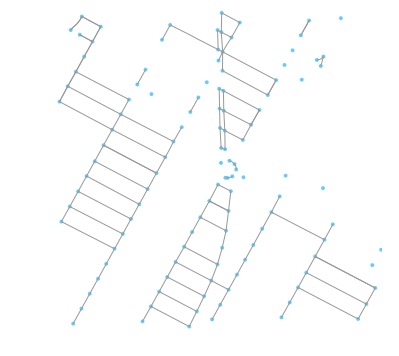

(<matplotlib.figure.Figure at 0x1c2a8f650>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2080b3390>)

In [51]:
subgraph = nyc.subgraph(local_nodes)
subgraph = ox.project_graph(subgraph)
ox.plot_graph(subgraph)